<a href="https://colab.research.google.com/github/alonba/eeg-bss/blob/main/FastICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import mne as mne
import matplotlib.pyplot as plt

ELECTRODES_NUM = 35

root_folder = r"C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss"
train_sub_folder = r"\data\after_ica\train"
test_sub_folder = r"\data\after_ica\test"
file_name = r"\reconstructed_"
file_ext = ".set"

In [8]:
# Fetch the data from the .set file
eeglab_epochs = mne.io.read_epochs_eeglab(root_folder + r'\data\35_electrodes_filtered_epoched.set')

# Create the train set and test set
total_num_of_epochs = len(eeglab_epochs)

train_set_indexes = []
test_set_indexes = []
for i in range(total_num_of_epochs):
    random_num = np.random.rand()
    if (random_num < 0.8):  # 80% chance of being here
        train_set_indexes.append(i)
    else:
        test_set_indexes.append(i)

train_set = eeglab_epochs[train_set_indexes]
test_set = eeglab_epochs[test_set_indexes]

print(len(train_set))
print(len(test_set))

Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\35_electrodes_filtered_epoched.set...
Not setting metadata
460 matching events found
No baseline correction applied
0 projection items activated
Ready.
368
92


In [9]:
# Export the Data
mne.export.export_epochs(root_folder + r'\data\train_set.set', train_set, overwrite=True)
mne.export.export_epochs(root_folder + r'\data\test_set.set', test_set, overwrite=True)

In [20]:
# Import the data
train_set = mne.io.read_epochs_eeglab(root_folder + r'\data\train_set.set')
test_set = mne.io.read_epochs_eeglab(root_folder + r'\data\test_set.set')

Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\train_set.set...
Not setting metadata
368 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\test_set.set...
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [3]:
train_ica = mne.preprocessing.ICA(n_components = ELECTRODES_NUM, method='picard')  # Defaults to FastICA
train_ica.fit(train_set)
TRAIN_SET_NUM_OF_TRIALS, _ , NUM_OF_TIME_SAMPLES_IN_TRIAL = train_set.get_data().shape

test_ica = mne.preprocessing.ICA(n_components = ELECTRODES_NUM, method='picard')  # Defaults to FastICA
test_ica.fit(test_set)
TEST_SET_NUM_OF_TRIALS = test_set.get_data().shape[0]

Fitting ICA to data using 35 channels (please be patient, this may take a while)


C:\Users\alonb\AppData\Local\Temp\ipykernel_29472\344785431.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  train_ica.fit(train_set)


Selecting by number: 35 components
Fitting ICA took 37.1s.
Fitting ICA to data using 35 channels (please be patient, this may take a while)
Selecting by number: 35 components


C:\Users\alonb\AppData\Local\Temp\ipykernel_29472\344785431.py:6: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  test_ica.fit(test_set)


Fitting ICA took 8.5s.


In [6]:
train_set_left = train_set['Left']
train_set_right = train_set['Right']
train_set_no_move = train_set['NoMove']

TRAIN_LEFT_NUM_OF_TRIALS = len(train_set_left.selection)
TRAIN_RIGHT_NUM_OF_TRIALS = len(train_set_right.selection)
TRAIN_NO_MOVE_NUM_OF_TRIALS = len(train_set_no_move.selection)

train_left_data = train_set_left.get_data()
train_right_data = train_set_right.get_data()
train_no_move_data = train_set_no_move.get_data()

train_left_data_swapped = np.swapaxes(train_left_data,0,1)
train_right_data_swapped = np.swapaxes(train_right_data,0,1)
train_no_move_data_swapped = np.swapaxes(train_no_move_data,0,1)

reshaped_train_set_left = train_left_data_swapped.reshape((ELECTRODES_NUM, TRAIN_LEFT_NUM_OF_TRIALS * NUM_OF_TIME_SAMPLES_IN_TRIAL))
reshaped_train_set_right = train_right_data_swapped.reshape((ELECTRODES_NUM, TRAIN_RIGHT_NUM_OF_TRIALS * NUM_OF_TIME_SAMPLES_IN_TRIAL))
reshaped_train_set_no_move = train_no_move_data_swapped.reshape((ELECTRODES_NUM, TRAIN_NO_MOVE_NUM_OF_TRIALS * NUM_OF_TIME_SAMPLES_IN_TRIAL))

train_ICs_left = train_ica.unmixing_matrix_ @ reshaped_train_set_left
train_ICs_right = train_ica.unmixing_matrix_ @ reshaped_train_set_right
train_ICs_no_move = train_ica.unmixing_matrix_ @ reshaped_train_set_no_move

train_ICs_left_reshaped = train_ICs_left.reshape((ELECTRODES_NUM, TRAIN_LEFT_NUM_OF_TRIALS, NUM_OF_TIME_SAMPLES_IN_TRIAL))
train_ICs_right_reshaped = train_ICs_right.reshape((ELECTRODES_NUM, TRAIN_RIGHT_NUM_OF_TRIALS, NUM_OF_TIME_SAMPLES_IN_TRIAL))
train_ICs_no_move_reshaped = train_ICs_no_move.reshape((ELECTRODES_NUM, TRAIN_NO_MOVE_NUM_OF_TRIALS, NUM_OF_TIME_SAMPLES_IN_TRIAL))

train_ICs = np.concatenate((train_ICs_left_reshaped, train_ICs_right_reshaped, train_ICs_no_move_reshaped), axis=1)
np.save('./data/train_ICS.npy', train_ICs) # save


In [7]:
test_set_left = test_set['Left']
test_set_right = test_set['Right']
test_set_no_move = test_set['NoMove']

TEST_LEFT_NUM_OF_TRIALS = len(test_set_left.selection)
TEST_RIGHT_NUM_OF_TRIALS = len(test_set_right.selection)
TEST_NO_MOVE_NUM_OF_TRIALS = len(test_set_no_move.selection)

test_left_data = test_set_left.get_data()
test_right_data = test_set_right.get_data()
test_no_move_data = test_set_no_move.get_data()

test_left_data_swapped = np.swapaxes(test_left_data,0,1)
test_right_data_swapped = np.swapaxes(test_right_data,0,1)
test_no_move_data_swapped = np.swapaxes(test_no_move_data,0,1)

reshaped_test_set_left = test_left_data_swapped.reshape((ELECTRODES_NUM, TEST_LEFT_NUM_OF_TRIALS * NUM_OF_TIME_SAMPLES_IN_TRIAL))
reshaped_test_set_right = test_right_data_swapped.reshape((ELECTRODES_NUM, TEST_RIGHT_NUM_OF_TRIALS * NUM_OF_TIME_SAMPLES_IN_TRIAL))
reshaped_test_set_no_move = test_no_move_data_swapped.reshape((ELECTRODES_NUM, TEST_NO_MOVE_NUM_OF_TRIALS * NUM_OF_TIME_SAMPLES_IN_TRIAL))

test_ICs_left = test_ica.unmixing_matrix_ @ reshaped_test_set_left
test_ICs_right = test_ica.unmixing_matrix_ @ reshaped_test_set_right
test_ICs_no_move = test_ica.unmixing_matrix_ @ reshaped_test_set_no_move

test_ICs_left_reshaped = test_ICs_left.reshape((ELECTRODES_NUM, TEST_LEFT_NUM_OF_TRIALS, NUM_OF_TIME_SAMPLES_IN_TRIAL))
test_ICs_right_reshaped = test_ICs_right.reshape((ELECTRODES_NUM, TEST_RIGHT_NUM_OF_TRIALS, NUM_OF_TIME_SAMPLES_IN_TRIAL))
test_ICs_no_move_reshaped = test_ICs_no_move.reshape((ELECTRODES_NUM, TEST_NO_MOVE_NUM_OF_TRIALS, NUM_OF_TIME_SAMPLES_IN_TRIAL))

test_ICs = np.concatenate((test_ICs_left_reshaped, test_ICs_right_reshaped, test_ICs_no_move_reshaped), axis=1)
np.save('./data/test_ICs.npy', test_ICs) # save


In [8]:
train_labels_left = np.full((TRAIN_LEFT_NUM_OF_TRIALS),1)
train_labels_right = np.full((TRAIN_RIGHT_NUM_OF_TRIALS),2)
train_labels_no_move = np.full((TRAIN_NO_MOVE_NUM_OF_TRIALS),3)
train_labels = np.concatenate((train_labels_left, train_labels_right, train_labels_no_move))
np.save('./data/train_labels.npy', train_labels) # save


test_labels_left = np.full((TEST_LEFT_NUM_OF_TRIALS),1)
test_labels_right = np.full((TEST_RIGHT_NUM_OF_TRIALS),2)
test_labels_no_move = np.full((TEST_NO_MOVE_NUM_OF_TRIALS),3)
test_labels = np.concatenate((test_labels_left, test_labels_right, test_labels_no_move))
np.save('./data/test_labels.npy', test_labels) # save


In [4]:
# Load data
train_ICS = np.load('./data/train_ICS.npy')
test_ICs = np.load('./data/test_ICs.npy')
train_labels = np.load('./data/train_labels.npy')
test_labels = np.load('./data/test_labels.npy')

In [106]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
classifiers = []
for c in (0.5,0.6,0.7,0.8,0.9,1,1.1):
    classifiers.append(svm.SVC(C=c, kernel='sigmoid'))  # Good results with RBF (default) and Sigmoid. Defaults to C=1.
k = 5
scores = np.empty((ELECTRODES_NUM,len(C),2))
for i in range(0, ELECTRODES_NUM, 1):
    for j in range(0,len(C),1):
        score = cross_val_score(classifiers[j], train_ICS[i], train_labels, cv=k)
        scores[i,j] = [score.mean(), score.std()]
print(scores)
# scores = -np.sort(-np.array(scores), axis=0)
# accuracies = scores[:,0]
# print(f"Using K={k}, the mean value is {accuracies.mean()}. The Max is {accuracies.max()} and Min is {accuracies.min()}. The overall STD is {accuracies.std()}")

[[[0.47549056 0.05243522]
  [0.45916327 0.05305413]
  [0.45375787 0.04854002]
  [0.461903   0.04958547]
  [0.45372084 0.05599831]
  [0.44831544 0.05315464]
  [0.44831544 0.04960026]]

 [[0.44838949 0.04877159]
  [0.44838949 0.05238223]
  [0.44013328 0.05934189]
  [0.42117734 0.05093815]
  [0.4320622  0.04257199]
  [0.41843762 0.05573955]
  [0.42924843 0.05609387]]

 [[0.51921511 0.03214243]
  [0.5165124  0.03414996]
  [0.51373565 0.03131206]
  [0.51106997 0.03776114]
  [0.51925213 0.05404239]
  [0.50844132 0.05600757]
  [0.50833025 0.04013779]]

 [[0.44013328 0.05182387]
  [0.44831544 0.05033122]
  [0.45109219 0.0496762 ]
  [0.45112921 0.04096543]
  [0.44842651 0.03788349]
  [0.44583488 0.04330662]
  [0.45124028 0.03227886]]

 [[0.41007034 0.04341155]
  [0.39655683 0.02772832]
  [0.38578304 0.01638214]
  [0.39663088 0.02731097]
  [0.38026657 0.02611087]
  [0.38022954 0.0331488 ]
  [0.39655683 0.03149647]]

 [[0.45923732 0.03940566]
  [0.45116623 0.0334338 ]
  [0.44835246 0.01849055]
  

<BarContainer object of 35 artists>

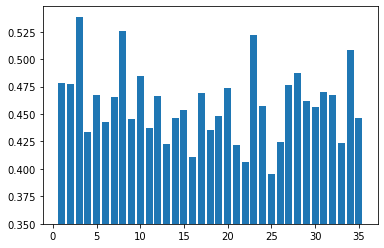

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

k = 35
scores = np.empty(ELECTRODES_NUM)
for i in range(ELECTRODES_NUM):
    clf = svm.SVC(C=0.7)
    score = cross_val_score(clf, train_ICS[i], train_labels, cv=k)
    scores[i] = score.mean()

x = np.arange(ELECTRODES_NUM) + 1
bottom = 0.35
plt.bar(x,scores-bottom,bottom=bottom)


In [ ]:
# train_left_reconstructed = []
# train_right_reconstructed = []
# train_no_move_reconstructed = []
# for i in range(ELECTRODES_NUM):
#     tmp_train_left = train_set_left.copy()
#     tmp_train_right = train_set_right.copy()
#     tmp_train_no_move = train_set_no_move.copy()
#     train_left_reconstructed.append(train_ica.apply(tmp_train_left,include=i))
#     train_right_reconstructed.append(train_ica.apply(tmp_train_right,include=i))
#     train_no_move_reconstructed.append(train_ica.apply(tmp_train_no_move,include=i))

In [21]:
### Export the projected data to .set files, EEGLAB format

# for i in range(ELECTRODES_NUM):
#     mne.export.export_epochs(root_folder+train_sub_folder+r"\left"+file_name+str(i)+file_ext,train_left_reconstructed[i])
#     mne.export.export_epochs(root_folder+train_sub_folder+r"\right"+file_name+str(i)+file_ext,train_right_reconstructed[i])
#     mne.export.export_epochs(root_folder+train_sub_folder+r"\no_move"+file_name+str(i)+file_ext,train_no_move_reconstructed[i])

In [ ]:
# test_set = mne.io.read_epochs_eeglab(root_folder+r'\data\test_set.set')
# test_ica = mne.preprocessing.ICA(n_components=ELECTRODES_NUM)  # Defaults to FastICA
# test_ica.fit(test_set)

# test_set_left=test_set['Left']
# test_set_right=test_set['Right']
# test_set_no_move=test_set['NoMove']

# test_left_reconstructed = []
# test_right_reconstructed = []
# test_no_move_reconstructed = []
# for i in range(ELECTRODES_NUM):
#     tmp_test_left = test_set_left.copy()
#     tmp_test_right = test_set_right.copy()
#     tmp_test_no_move = test_set_no_move.copy()
#     test_left_reconstructed.append(test_ica.apply(tmp_test_left,include=i))
#     test_right_reconstructed.append(test_ica.apply(tmp_test_right,include=i))
#     test_no_move_reconstructed.append(test_ica.apply(tmp_test_no_move,include=i))
    
# # Export the projected data to .set files, EEGLAB format
# for i in range(ELECTRODES_NUM):
#     mne.export.export_epochs(root_folder+test_sub_folder+r"\left"+file_name+str(i)+file_ext,test_left_reconstructed[i])
#     mne.export.export_epochs(root_folder+test_sub_folder+r"\right"+file_name+str(i)+file_ext,test_right_reconstructed[i])
#     mne.export.export_epochs(root_folder+test_sub_folder+r"\no_move"+file_name+str(i)+file_ext,test_no_move_reconstructed[i])

In [ ]:
# ### Import the projected data

# train_left_reconstructed=[]
# train_right_reconstructed=[]
# train_no_move_reconstructed=[]
# test_left_reconstructed=[]
# test_right_reconstructed=[]
# test_no_move_reconstructed=[]
# for i in range(ELECTRODES_NUM):
#     train_left_reconstructed.append(mne.read_epochs_eeglab(root_folder+train_sub_folder+r"\left"+file_name+str(i)+file_ext))
#     train_right_reconstructed.append(mne.read_epochs_eeglab(root_folder+train_sub_folder+r"\right"+file_name+str(i)+file_ext))
#     train_no_move_reconstructed.append(mne.read_epochs_eeglab(root_folder+train_sub_folder+r"\no_move"+file_name+str(i)+file_ext))
#     test_left_reconstructed.append(mne.read_epochs_eeglab(root_folder+test_sub_folder+r"\left"+file_name+str(i)+file_ext))
#     test_right_reconstructed.append(mne.read_epochs_eeglab(root_folder+test_sub_folder+r"\right"+file_name+str(i)+file_ext))
#     test_no_move_reconstructed.append(mne.read_epochs_eeglab(root_folder+test_sub_folder+r"\no_move"+file_name+str(i)+file_ext))